
# Filter Data Availability Strip Chart

This notebook builds the site-level strip chart and supporting counts requested in the MAIA data availability review.



**Goals**

- Visualize sample-day availability for FTIR-EC, HIPS Fabs, and Aethalometer data across Addis Ababa (ETAD), Pasadena/JPL (USPA), Beijing (CHTS), and Delhi (INDH).
- Summarize the number of days with paired FTIR+HIPS measurements, and where available, days with all three data sets.
- Verify that JPL (USPA) has no FTIR/HIPS sample dates after December 2023 so we avoid analysis-date mix-ups.


In [39]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', context='talk')
plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.facecolor': 'white'
})

print('✅ Libraries loaded')


✅ Libraries loaded


In [40]:

# Paths and site configuration
BASE_DIR = Path.cwd()
FILTER_DB_PATH = (BASE_DIR / "../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl").resolve()

AETH_PATHS = {
    'ETAD': (BASE_DIR / "../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl").resolve(),
    'USPA': None,  # Placeholder – no local aethalometer PKL committed yet
    'CHTS': None,
    'INDH': None,
}

SITE_DISPLAY_NAMES = {
    'ETAD': 'Addis Ababa',
    'USPA': 'Pasadena / JPL',
    'CHTS': 'Beijing',
    'INDH': 'Delhi'
}

MEASUREMENT_ORDER = ['FTIR-EC', 'HIPS Fabs', 'Aethalometer']
MEASUREMENT_POSITIONS = {name: idx for idx, name in enumerate(MEASUREMENT_ORDER)}
PALETTE = {
    'FTIR-EC': '#1f77b4',
    'HIPS Fabs': '#ff7f0e',
    'Aethalometer': '#2ca02c'
}

print(f"📂 Working directory: {BASE_DIR}")
print(f"📄 Filter DB path: {FILTER_DB_PATH}")
for site, path in AETH_PATHS.items():
    print(f"   Aeth path {site}: {path if path else '—'}")


📂 Working directory: /Users/ahzs645/Github/aethmodular-clean/notebooks
📄 Filter DB path: /Users/ahzs645/Github/aethmodular-clean/FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl
   Aeth path ETAD: /Users/ahzs645/Github/aethmodular-clean/FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl
   Aeth path USPA: —
   Aeth path CHTS: —
   Aeth path INDH: —


In [41]:

# Load and filter the unified filter dataset
filter_df = pd.read_pickle(FILTER_DB_PATH)
filter_df['SampleDate'] = pd.to_datetime(filter_df['SampleDate'], errors='coerce')
filter_df = filter_df.dropna(subset=['SampleDate']).copy()
filter_df['SampleDate'] = filter_df['SampleDate'].dt.normalize()
filter_df['Site'] = filter_df['Site'].astype(str)

sites_of_interest = list(SITE_DISPLAY_NAMES.keys())
filter_df = filter_df[filter_df['Site'].isin(sites_of_interest)].copy()

print('🔢 Total filter records kept:', len(filter_df))
filter_df[['Site', 'DataSource', 'Parameter', 'SampleDate']].head()


🔢 Total filter records kept: 42981


,Site,DataSource,Parameter,SampleDate
0,CHTS,ChemSpec,ChemSpec_Ammonium_Ion_PM2.5,2013-09-02
1,CHTS,ChemSpec,ChemSpec_Bromide_Ion_PM2.5,2013-09-02
2,CHTS,ChemSpec,ChemSpec_Calcium_Ion_PM2.5,2013-09-02
3,CHTS,ChemSpec,ChemSpec_Filter_PM2.5_mass,2013-09-02
4,CHTS,ChemSpec,ChemSpec_Filter_PM2.5_mass,2013-09-02


In [42]:

# Helper functions to assemble availability records

def build_filter_measurement(df, data_source, parameter, label):
    subset = df[(df['DataSource'] == data_source) & (df['Parameter'] == parameter)].copy()
    subset = subset[['Site', 'SampleDate']].drop_duplicates()
    subset['MeasurementType'] = label
    return subset

availability_frames = [
    build_filter_measurement(filter_df, 'FTIR', 'EC_ftir', 'FTIR-EC'),
    build_filter_measurement(filter_df, 'HIPS', 'HIPS_Fabs', 'HIPS Fabs')
]

missing_aeth_sites = []
for site_code, path in AETH_PATHS.items():
    if path and path.exists():
        aeth_df = pd.read_pickle(path)
        if 'datetime_local' in aeth_df.columns:
            dt = pd.to_datetime(aeth_df['datetime_local'], errors='coerce')
        else:
            dt = pd.to_datetime(aeth_df.index, errors='coerce')
        dt = dt.dropna()
        if hasattr(dt, 'dt') and dt.dt.tz is not None:
            dt = dt.dt.tz_localize(None)
        dates = pd.Series(dt.dt.normalize().unique()).dropna()
        if not dates.empty:
            temp = pd.DataFrame({
                'Site': site_code,
                'SampleDate': pd.to_datetime(dates.values),
                'MeasurementType': 'Aethalometer'
            })
            availability_frames.append(temp)
        else:
            missing_aeth_sites.append(site_code)
    else:
        missing_aeth_sites.append(site_code)

if availability_frames:
    chart_data = pd.concat(availability_frames, ignore_index=True)
else:
    chart_data = pd.DataFrame(columns=['Site', 'SampleDate', 'MeasurementType'])

chart_data['SiteName'] = chart_data['Site'].map(SITE_DISPLAY_NAMES)
chart_data['MeasurementType'] = pd.Categorical(chart_data['MeasurementType'], categories=MEASUREMENT_ORDER, ordered=True)
chart_data = chart_data.dropna(subset=['SampleDate']).drop_duplicates()
chart_data['MeasurementPos'] = chart_data['MeasurementType'].map(MEASUREMENT_POSITIONS).astype(float)

print('📈 Availability records:', len(chart_data))
if missing_aeth_sites:
    print('⚠️ Aethalometer PKL not found for sites:', ', '.join(sorted(missing_aeth_sites)))

chart_data.head()


📈 Availability records: 2224
⚠️ Aethalometer PKL not found for sites: CHTS, INDH, USPA


,Site,SampleDate,MeasurementType,SiteName,MeasurementPos
0,CHTS,2022-07-05,FTIR-EC,Beijing,0.0
1,CHTS,2022-07-14,FTIR-EC,Beijing,0.0
2,CHTS,2022-07-23,FTIR-EC,Beijing,0.0
3,CHTS,2022-08-01,FTIR-EC,Beijing,0.0
4,CHTS,2022-08-10,FTIR-EC,Beijing,0.0


In [43]:

# Build per-site counts for FTIR, HIPS, and Aethalometer availability and overlaps
count_rows = []
for site in SITE_DISPLAY_NAMES:
    site_mask = chart_data['Site'] == site
    ft_dates = set(chart_data.loc[site_mask & (chart_data['MeasurementType'] == 'FTIR-EC'), 'SampleDate'])
    hips_dates = set(chart_data.loc[site_mask & (chart_data['MeasurementType'] == 'HIPS Fabs'), 'SampleDate'])
    aeth_dates = set(chart_data.loc[site_mask & (chart_data['MeasurementType'] == 'Aethalometer'), 'SampleDate'])

    count_rows.append({
        'Site': SITE_DISPLAY_NAMES[site],
        'FTIR Days': len(ft_dates),
        'HIPS Days': len(hips_dates),
        'Aeth Days': len(aeth_dates),
        'FTIR + HIPS Days': len(ft_dates & hips_dates),
        'FTIR + HIPS + Aeth Days': len(ft_dates & hips_dates & aeth_dates) if aeth_dates else 0
    })

counts_df = pd.DataFrame(count_rows)
counts_df


,Site,FTIR Days,HIPS Days,Aeth Days,FTIR + HIPS Days,FTIR + HIPS + Aeth Days
0,Addis Ababa,189,189,1047,189,172
1,Pasadena / JPL,158,130,0,130,0
2,Beijing,190,161,0,161,0
3,Delhi,97,63,0,63,0


In [44]:

# Sanity check: ensure no USPA (Pasadena/JPL) sample dates occur in 2024
jpl_late = chart_data[
    (chart_data['Site'] == 'USPA') &
    (chart_data['MeasurementType'].isin(['FTIR-EC', 'HIPS Fabs'])) &
    (chart_data['SampleDate'] >= '2024-01-01')
]

if not jpl_late.empty:
    display(jpl_late.sort_values('SampleDate'))
    raise ValueError('Unexpected USPA sample dates detected in 2024 – investigate sample vs analysis dates.')
else:
    print('✅ JPL (USPA) shows no FTIR/HIPS sample dates after 2023-12-31.')


✅ JPL (USPA) shows no FTIR/HIPS sample dates after 2023-12-31.


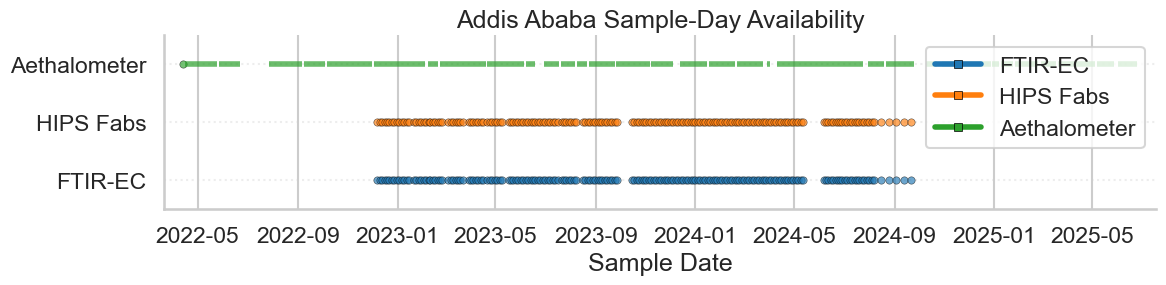

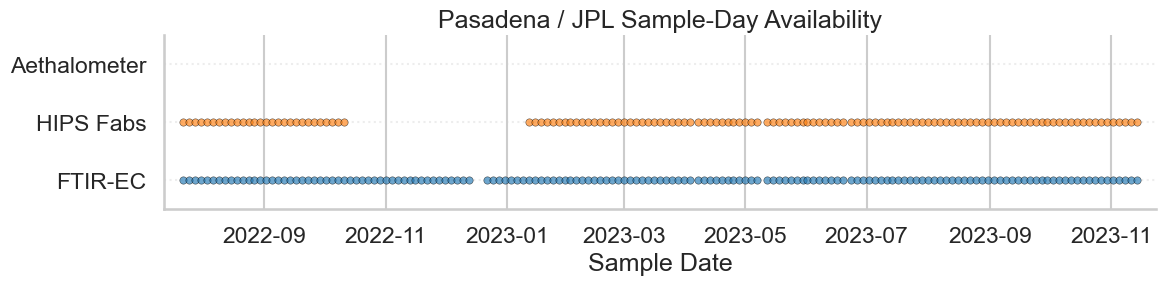

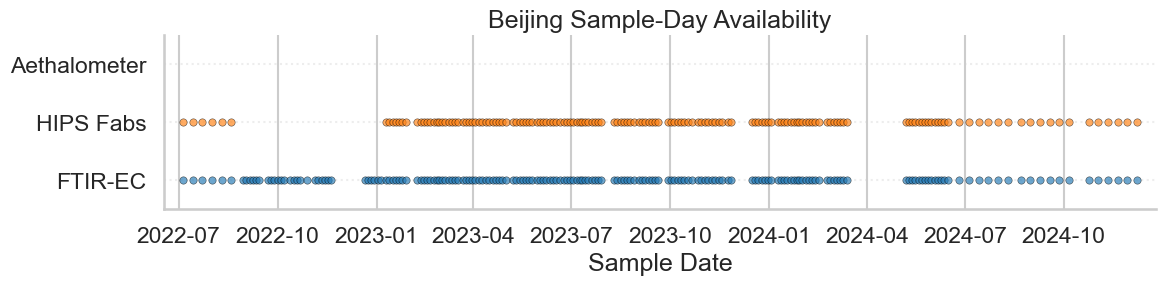

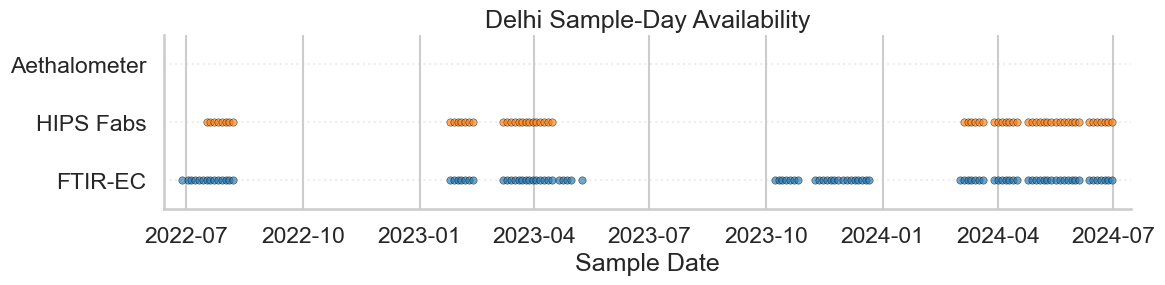

In [45]:

# Create individual strip charts per site for better readability
if chart_data.empty:
    print('No availability data to plot.')
else:
    legend_handles = [
        Line2D(
            [0, 1],
            [0, 0],
            marker='s',
            linestyle='-',
            color=PALETTE[m],
            markerfacecolor=PALETTE[m],
            markeredgecolor='black',
            markeredgewidth=0.5,
            linewidth=4.0,
            markersize=6,
            label=m
        )
        for m in MEASUREMENT_ORDER
    ]

    def _consecutive_segments(date_series):
        dates = pd.to_datetime(date_series).dropna().sort_values().unique()
        if len(dates) == 0:
            return []
        segments = []
        current_segment = [dates[0]]
        for prev, curr in zip(dates, dates[1:]):
            if (curr - prev) == np.timedelta64(1, 'D'):
                current_segment.append(curr)
            else:
                segments.append(current_segment)
                current_segment = [curr]
        segments.append(current_segment)
        return segments

    for idx, (site_code, site_label) in enumerate(SITE_DISPLAY_NAMES.items()):
        site_df = chart_data[chart_data['Site'] == site_code]
        fig, ax = plt.subplots(figsize=(12, 3.2))

        if site_df.empty:
            ax.text(0.5, 0.5, 'No data available', transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, fontweight='bold')
            ax.set_axis_off()
        else:
            for measurement in MEASUREMENT_ORDER:
                measurement_df = site_df[site_df['MeasurementType'] == measurement]
                if measurement_df.empty:
                    continue

                segments = _consecutive_segments(measurement_df['SampleDate'])
                y_value = MEASUREMENT_POSITIONS[measurement]
                singletons = []

                for segment in segments:
                    if len(segment) > 1:
                        x_vals = pd.to_datetime(segment)
                        ax.hlines(
                            y=y_value,
                            xmin=x_vals.min(),
                            xmax=x_vals.max(),
                            color=PALETTE[measurement],
                            linewidth=4.0,
                            alpha=0.7,
                            label=measurement if idx == 0 else None
                        )
                    else:
                        singletons.extend(segment)

                if singletons:
                    x_vals = pd.to_datetime(singletons)
                    y_values = np.full(len(x_vals), y_value, dtype=float)
                    ax.scatter(
                        x_vals,
                        y_values,
                        color=PALETTE[measurement],
                        edgecolor='black',
                        linewidth=0.4,
                        s=28,
                        alpha=0.65,
                        label=measurement if idx == 0 and not segments else None
                    )

            ax.set_yticks(list(MEASUREMENT_POSITIONS.values()))
            ax.set_yticklabels(MEASUREMENT_ORDER)
            ax.set_ylim(-0.5, len(MEASUREMENT_ORDER) - 0.5)
            ax.set_xlabel('Sample Date')
            ax.set_ylabel('')
            ax.set_title(f'{site_label} Sample-Day Availability')
            ax.grid(axis='y', linestyle=':', alpha=0.35)
            ax.margins(x=0.02)

            if idx == 0:
                ax.legend(handles=legend_handles, loc='upper right', frameon=True)

        plt.tight_layout()
        plt.show()


In [38]:

# Display the counts table in a compact format
counts_display = counts_df.set_index('Site').sort_index()
counts_display


,FTIR Days,HIPS Days,Aeth Days,FTIR + HIPS Days,FTIR + HIPS + Aeth Days
Site,,,,,
Addis Ababa,189,189,1047,189,172
Beijing,190,161,0,161,0
Delhi,97,63,0,63,0
Pasadena / JPL,158,130,0,130,0



### Notes

- Aethalometer availability is currently only ingested for Addis Ababa (ETAD); the other sites will populate once their PKL exports are committed.
- All availability calculations rely on *SampleDate* to avoid the analysis-date mix-up noted for JPL 2024. The validation cell confirms there are no USPA FTIR/HIPS samples dated after December 2023.
- The counts table highlights days with paired FTIR+HIPS observations and, where available, triple overlaps including the aethalometer.
